# 

In [29]:
# windows 11 platform, python3.11

# !pip install pyhealth
# !pip install nltk
# !pip install pytorch

# Attempt that combine 2 datasets:
1. author provide 3000 synthetic patients data
2. mimic3 data from pyhealth

# 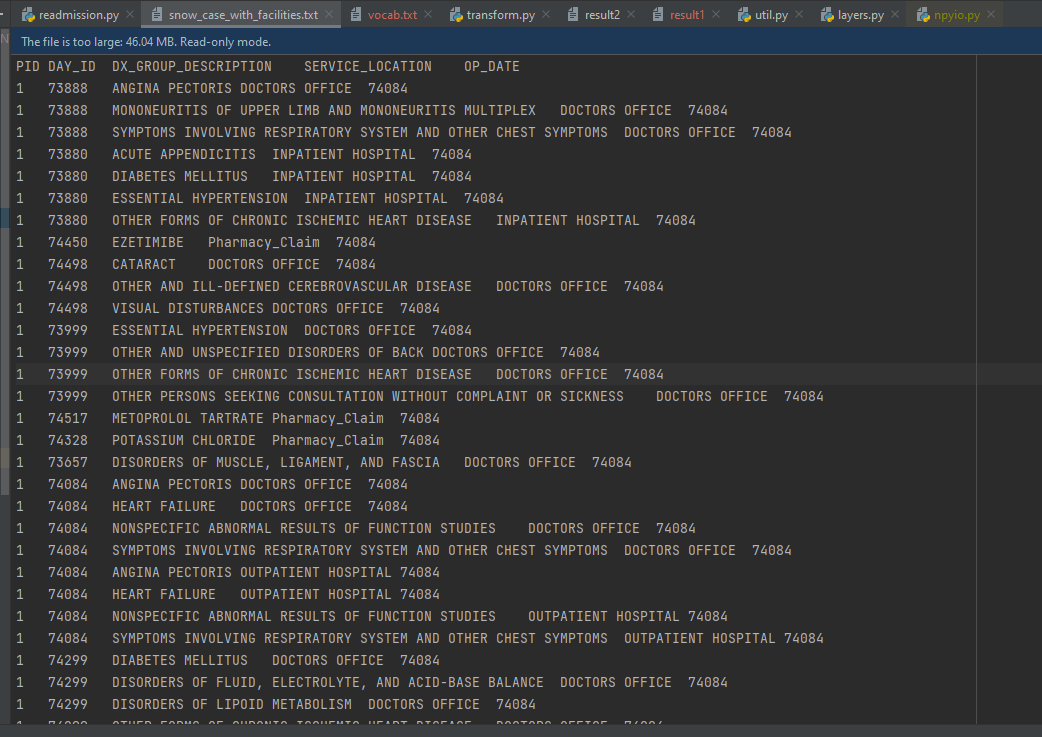

## Load dataset

description on each table here:

1. DIAGNOSES_ICD: https://mimic.mit.edu/docs/iii/tables/diagnoses_icd/

ROW_ID, SUBJECT_ID, HADM_ID, SEQ_NUM, ICD9_CODE
SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.
SEQ_NUM provides the order in which the ICD diagnoses relate to the patient
ICD9_CODE contains the actual code corresponding to the diagnosis assigned to the patient for the given row

Links to:

PATIENTS on SUBJECT_ID
ADMISSIONS on HADM_ID
D_ICD_DIAGNOSES on ICD9_CODE

2. PROCEDURES_ICD: https://mimic.mit.edu/docs/iii/tables/procedures_icd/

ROW_ID, SUBJECT_ID, HADM_ID, SEQ_NUM, ICD9_CODE

ICD9_CODE provides the ICD-9 code for the given procedure

3. PRESCRIPTIONS: https://mimic.mit.edu/docs/iii/tables/prescriptions/

ROW_ID, SUBJECT_ID, HADM_ID, ICUSTAY_ID, DRUG

Links to:

PATIENTS on SUBJECT_ID
ADMISSIONS on HADM_ID
ICUSTAYS on ICUSTAY_ID

In [1]:
import pandas as pd
from tqdm.autonotebook import tqdm 
from pyhealth.datasets import MIMIC3Dataset
pd.set_option('display.max_rows', 100)

C:\Users\liyim\AppData\Local\Temp\ipykernel_16112\613533823.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:


mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
#         tables=["ADMISSIONS",],
)

mimic3_ds.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PROCEDURES_ICD: 3.2186
	- Number of events per visit in PRESCRIPTIONS: 25.9600



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 49993\n\t- Number of visits: 52769\n\t- Number of visits per patient: 1.0555\n\t- Number of events per visit in DIAGNOSES_ICD: 9.1038\n\t- Number of events per visit in PROCEDURES_ICD: 3.2186\n\t- Number of events per visit in PRESCRIPTIONS: 25.9600\n'

In [3]:
# data format
mimic3_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



In [4]:
mimic3_ds.patients['10092']

Patient 10092 with 2 visits

In [5]:
mimic3_ds.patients['10092'].index_to_visit_id

{0: '110429', 1: '110430'}

In [6]:
mimic3_ds.patients['10092'].visits['110429']

Visit 110429 from patient 10092 with 15 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS']

In [7]:
mimic3_ds.patients['10092'].visits['110429'].event_list_dict

{'DIAGNOSES_ICD': [Event with ICD9CM code 53081 from table DIAGNOSES_ICD,
  Event with ICD9CM code 5715 from table DIAGNOSES_ICD,
  Event with ICD9CM code 5185 from table DIAGNOSES_ICD,
  Event with ICD9CM code 5180 from table DIAGNOSES_ICD,
  Event with ICD9CM code 1623 from table DIAGNOSES_ICD,
  Event with ICD9CM code 5672 from table DIAGNOSES_ICD,
  Event with ICD9CM code 8748 from table DIAGNOSES_ICD,
  Event with ICD9CM code 7812 from table DIAGNOSES_ICD,
  Event with ICD9CM code 3229 from table DIAGNOSES_ICD],
 'PROCEDURES_ICD': [Event with ICD9PROC code 3409 from table PROCEDURES_ICD],
 'PRESCRIPTIONS': [Event with NDC code 00034120081 from table PRESCRIPTIONS,
  Event with NDC code 00054858324 from table PRESCRIPTIONS,
  Event with NDC code 63323026201 from table PRESCRIPTIONS,
  Event with NDC code 00781305714 from table PRESCRIPTIONS,
  Event with NDC code 00310013039 from table PRESCRIPTIONS]}

In [8]:
mimic3_ds.patients['10092'].visits['110429'].event_list_dict['DIAGNOSES_ICD'][0]

Event with ICD9CM code 53081 from table DIAGNOSES_ICD

In [9]:
mimic3_ds.patients['10092'].visits['110429'].event_list_dict['DIAGNOSES_ICD'][0].code

'53081'

In [10]:
mimic3_ds.patients['10092'].visits['110429'].get_code_list(table="DIAGNOSES_ICD")

['53081', '5715', '5185', '5180', '1623', '5672', '8748', '7812', '3229']

In [11]:
mimic3_ds.patients['10092'].visits['110429'].event_list_dict['PROCEDURES_ICD'][0]

Event with ICD9PROC code 3409 from table PROCEDURES_ICD

In [12]:
mimic3_ds.patients['10092'].visits['110429'].event_list_dict['PRESCRIPTIONS'][0]

Event with NDC code 00034120081 from table PRESCRIPTIONS

In [13]:
mimic3_ds.tables

['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS']

In [14]:
from pyhealth.medcode import InnerMap
icd9cm = InnerMap.load("ICD9CM")
print(icd9cm.lookup("53081"))
print(icd9cm.lookup("7812"))

icd9proc = InnerMap.load("ICD9PROC")
print(icd9proc.lookup("3409"))

ndc = InnerMap.load("NDC")
print(ndc.lookup("00054858324"))

Esophageal reflux
Abnormality of gait
Other incision of pleura
Morphine Sulfate 30 MG Oral Tablet


In [15]:
# mimic3_ds.samples[0]

In [16]:
from pyhealth.data import Patient, Visit
def readmission_prediction_mimic3_fn(patient: Patient, time_window=15):
    """Processes a single patient for the readmission prediction task.

    Readmission prediction aims at predicting whether the patient will be readmitted
    into hospital within time_window days based on the clinical information from
    current visit (e.g., conditions and procedures).

    Args:
        patient: a Patient object
        time_window: the time window threshold (gap < time_window means label=1 for
            the task)

    Returns:
        samples: a list of samples, each sample is a dict with patient_id, visit_id,
            and other task-specific attributes as key

    Note that we define the task as a binary classification task.

    Examples:
        >>> from pyhealth.datasets import MIMIC3Dataset
        >>> mimic3_base = MIMIC3Dataset(
        ...    root="/srv/local/data/physionet.org/files/mimiciii/1.4",
        ...    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        ...    code_mapping={"ICD9CM": "CCSCM"},
        ... )
        >>> from pyhealth.tasks import readmission_prediction_mimic3_fn
        >>> mimic3_sample = mimic3_base.set_task(readmission_prediction_mimic3_fn)
        >>> mimic3_sample.samples[0]
        [{'visit_id': '130744', 'patient_id': '103', 'conditions': [['42', '109', '19', '122', '98', '663', '58', '51']], 'procedures': [['1']], 'label': 1}]
    """
    samples = []

    # we will drop the last visit
    for i in range(len(patient) - 1):
        visit: Visit = patient[i]
        next_visit: Visit = patient[i + 1]

        # get time difference between current visit and next visit
        time_diff = (next_visit.encounter_time - visit.encounter_time).days
        readmission_label = 1 if time_diff < time_window else 0

        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        # exclude: visits without condition, procedure, or drug code
        if len(conditions) * len(procedures) * len(drugs) == 0:
            continue
#         # TODO: should also exclude visit with age < 18
#         print(patient.patient_id,visit.visit_id)
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": [conditions],
                "procedures": [procedures],
                "drugs": [drugs],
                "label": readmission_label,
            }
        )
    # no cohort selection
    return samples

In [22]:

from pyhealth.medcode import InnerMap
icd9cm = InnerMap.load("ICD9CM")
print(icd9cm.lookup("53081"))

icd9proc = InnerMap.load("ICD9PROC")
print(icd9proc.lookup("3409"))

ndc = InnerMap.load("NDC")
print(ndc.lookup("00054858324"))

missing = 0
result = []
# loop through each patient/patient_id
for patient_id in tqdm(mimic3_ds.patients.keys()):
    patient = mimic3_ds.patients[patient_id]
#     print(type(patient))

    visit_id_list = patient.visits.keys()
    if len(visit_id_list) <= 1:
        continue # we do not care about patient that have only 1 visit, no readmission!
    
    # loop through each visit    
    for visit_id in visit_id_list:
        visit = patient.visits[visit_id]
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        for condition in conditions:
            try:
                result.append([patient_id, visit_id, visit.encounter_time, "condition", condition, icd9cm.lookup(condition)])
            except:
                missing+=1
#                 print("cannot find icd9cm.lookup(condition)", condition)
        for procedure in procedures:
            try:
                result.append([patient_id, visit_id, visit.encounter_time, "procedure", procedure, icd9proc.lookup(procedure)])
            except:
                missing+=1
#                 print("cannot find icd9proc.lookup(procedure)", procedure)
        for drug in drugs:
            try:
                pass
                #result.append([patient_id, visit_id, visit.encounter_time, "drug", drug, ndc.lookup(drug)])
            except:
                missing+=1
#                 print("cannot find ndc.lookup(drug)", drug)
    #break

data = pd.DataFrame(result, columns = ['patient_id', 'visit_id', 'encounter_time', 'event_type', 'event_code', 'event_desc'])


Esophageal reflux
Other incision of pleura
Morphine Sulfate 30 MG Oral Tablet


100%|████████████████████████████████████████████████████████████████████████| 49993/49993 [00:00<00:00, 198997.11it/s]


In [23]:
data.patient_id.unique().size

2339

In [24]:
data

,patient_id,visit_id,encounter_time,event_type,event_code,event_desc
0,10009,110342,1896-01-05,condition,5789,"Hemorrhage of gastrointestinal tract, unspecified"
1,10009,110342,1896-01-05,condition,2724,Other and unspecified hyperlipidemia
2,10009,110342,1896-01-05,condition,45620,Esophageal varices in diseases classified else...
3,10009,110342,1896-01-05,condition,78659,Other chest pain
4,10009,110342,1896-01-05,condition,45981,"Venous (peripheral) insufficiency, unspecified"
...,...,...,...,...,...,...
50693,9998,110330,2158-02-26,procedure,3199,Other operations on trachea
50694,9998,110331,2158-03-06,condition,4280,"Congestive heart failure, unspecified"
50695,9998,110331,2158-03-06,condition,99859,Other postoperative infection
50696,9998,110331,2158-03-06,condition,56211,Diverticulitis of colon (without mention of he...


In [25]:
# we will pick top 200 code and create a word_bag for mapping
top_words = data.groupby('event_desc')['visit_id'].count().reset_index().sort_values(by='visit_id', ascending=False)\
            ['event_desc'].head(200).values
index_to_words = {}
words_to_index = {}
cnt = 1
for word in top_words:
    index_to_words[cnt] = word
    words_to_index[word] = cnt
    cnt+=1

In [26]:
top_words

array(['Unspecified essential hypertension',
       'Congestive heart failure, unspecified', 'Atrial fibrillation',
       'Coronary atherosclerosis of native coronary artery',
       'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
       'Venous catheterization, not elsewhere classified',
       'Acute kidney failure, unspecified', 'Transfusion of packed cells',
       'Other and unspecified hyperlipidemia', 'Esophageal reflux',
       'Extracorporeal circulation auxiliary to open heart surgery',
       'Urinary tract infection, site not specified',
       'Pure hypercholesterolemia', 'Unspecified acquired hypothyroidism',
       'Acute respiratory failure',
       'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
       'Insertion of endotracheal tube',
       'Chronic airway obstruction, not elsewhere classified',
       'Enteral infusion of concentrated nutritional substances',
       'Acut

# However, this approach ends here since the word bag from MIMIC3 data is not at all similar with the synthetic dataset provided by the original paper. Due to limited medical knowledge we abandon this approach that combine 2 datasets.

# reason can be:
1. vocabulary can be different
2. original paper wrote that medicine prescription is used in evert/wordbag, however it does not show on top words
3. original dataset 'DX_GROUP_DESCRIPTION' column has been processed


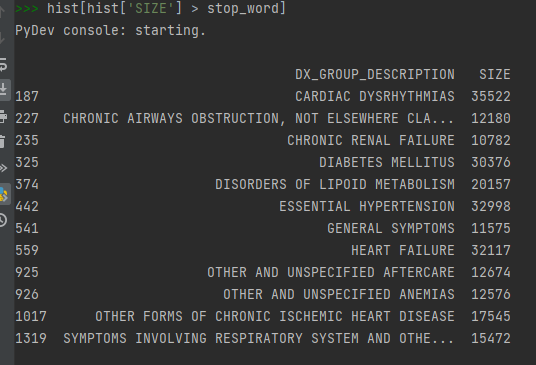

In [35]:
data['code_new'] = data['event_desc'].apply(lambda x: words_to_index.get(x, -1))
data.head()

,patient_id,visit_id,encounter_time,event_type,event_code,event_desc,code_new
0,10009,110342,1896-01-05,condition,5789,"Hemorrhage of gastrointestinal tract, unspecified",-1
1,10009,110342,1896-01-05,condition,2724,Other and unspecified hyperlipidemia,49
2,10009,110342,1896-01-05,condition,45620,Esophageal varices in diseases classified else...,-1
3,10009,110342,1896-01-05,condition,78659,Other chest pain,-1
4,10009,110342,1896-01-05,condition,45981,"Venous (peripheral) insufficiency, unspecified",-1


In [36]:
data[data['code_new']!=-1]

,patient_id,visit_id,encounter_time,event_type,event_code,event_desc,code_new
1,10009,110342,1896-01-05,condition,2724,Other and unspecified hyperlipidemia,49
8,10009,110342,1896-01-05,drug,00008092355,pantoprazole 40 MG Injection [Protonix],18
9,10009,110342,1896-01-05,drug,00409176230,1 ML morphine sulfate 2 MG/ML Prefilled Syringe,23
10,10009,110342,1896-01-05,drug,61553008348,Calcium Gluconate 20 MG/ML Injectable Solution,147
11,10009,110342,1896-01-05,drug,63323026201,"heparin sodium, porcine 5000 UNT/ML Injectable...",4
...,...,...,...,...,...,...,...
160343,9998,110330,2158-02-26,drug,00031670972,Metoclopramide 5 MG/ML Injectable Solution [Re...,179
160345,9998,110330,2158-02-26,drug,00597001314,200 ACTUAT Albuterol 0.09 MG/ACTUAT / Ipratrop...,156
160348,9998,110330,2158-02-26,drug,00182125989,Trazodone Hydrochloride 50 MG Oral Tablet,115
160353,9998,110330,2158-02-26,drug,00054865024,Acetaminophen 325 MG / Oxycodone Hydrochloride...,153


## Define healthcare task 

In [37]:
# from pyhealth.tasks import readmission_prediction_mimic3_fn

mimic3_ds_new = mimic3_ds.set_task(task_fn=readmission_prediction_mimic3_fn)
# stats info
mimic3_ds_new.stat()

Generating samples for readmission_prediction_mimic3_fn: 100%|███████████████| 49993/49993 [00:00<00:00, 306123.23it/s]


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: readmission_prediction_mimic3_fn
	- Number of samples: 2194
	- Number of patients: 2116
	- Number of visits: 2194
	- Number of visits per patient: 1.0369
	- conditions:
		- Number of conditions per sample: 10.3414
		- Number of unique conditions: 2526
		- Distribution of conditions (Top-10): [('4019', 875), ('41401', 591), ('42731', 540), ('25000', 483), ('4280', 472), ('2724', 324), ('5849', 297), ('53081', 280), ('5990', 264), ('2720', 254)]
	- procedures:
		- Number of procedures per sample: 4.0789
		- Number of unique procedures: 815
		- Distribution of procedures (Top-10): [('3893', 458), ('3961', 419), ('9904', 393), ('8856', 250), ('3615', 234), ('9604', 222), ('966', 213), ('8872', 208), ('9671', 181), ('3722', 177)]
	- drugs:
		- Number of drugs per sample: 35.5228
		- Number of unique drugs: 2424
		- Distribution of drugs (Top-10): [('00338001702', 1023), ('00008084199', 903), ('51079025520', 893), ('00338004938

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: readmission_prediction_mimic3_fn\n\t- Number of samples: 2194\n\t- Number of patients: 2116\n\t- Number of visits: 2194\n\t- Number of visits per patient: 1.0369\n\t- conditions:\n\t\t- Number of conditions per sample: 10.3414\n\t\t- Number of unique conditions: 2526\n\t\t- Distribution of conditions (Top-10): [('4019', 875), ('41401', 591), ('42731', 540), ('25000', 483), ('4280', 472), ('2724', 324), ('5849', 297), ('53081', 280), ('5990', 264), ('2720', 254)]\n\t- procedures:\n\t\t- Number of procedures per sample: 4.0789\n\t\t- Number of unique procedures: 815\n\t\t- Distribution of procedures (Top-10): [('3893', 458), ('3961', 419), ('9904', 393), ('8856', 250), ('3615', 234), ('9604', 222), ('966', 213), ('8872', 208), ('9671', 181), ('3722', 177)]\n\t- drugs:\n\t\t- Number of drugs per sample: 35.5228\n\t\t- Number of unique drugs: 2424\n\t\t- Distribution of drugs (Top-10): [('00338001702', 1023), ('000080841

In [39]:
mimic3_ds_new.samples[4]

{'visit_id': '101067',
 'patient_id': '1014',
 'conditions': [['5990', '5559', '25000', 'V090', '20280', '7905', '71596']],
 'procedures': [['5551']],
 'drugs': [['00074729501', '54569022500', '00008058107', '63323036820']],
 'label': 0}

In [40]:
len(mimic3_ds_new.samples)

2194

In [43]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds_new, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

## Define ML Model 

In [44]:
from pyhealth.models import Transformer

model = Transformer(
    dataset=mimic3_ds_new,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["conditions", "procedures"],
    label_key="label",
    mode="binary",
)

## training

In [45]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=3,
    monitor="pr_auc",
)

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(2528, 128, padding_idx=0)
    (procedures): Embedding(817, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (i

##  Evaluation

In [46]:
# option 1: use our built-in evaluation metric
score = trainer.evaluate(test_loader)
print (score)

# option 2: use our pyhealth.metrics to evaluate
from pyhealth.metrics.binary import binary_metrics_fn
y_true, y_prob, loss = trainer.inference(test_loader)
binary_metrics_fn(y_true, y_prob, metrics=["pr_auc"])

Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 161.36it/s]


{'pr_auc': 0.15019313820734978, 'roc_auc': 0.46232339089481944, 'f1': 0.0, 'loss': 0.5978050008416176}


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 190.33it/s]


{'pr_auc': 0.15019313820734978}

# appendix

In [79]:
import pickle
import numpy as np



path = "../resource/X_train.pkl"
with open(path, 'rb') as f:
    obj = pickle.load(f)
    print(" [*] load %s" % path)

x = pd.DataFrame(obj)
x.shape


path = "../resource/Y_train.pkl"
with open(path, 'rb') as f:
    obj = pickle.load(f)
    print(" [*] load %s" % path)

y = pd.DataFrame(obj)
y.shape

 [*] load ../resource/X_train.pkl
 [*] load ../resource/Y_train.pkl


(2000, 327)

In [80]:
x

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,326
0,"[406, 273, 485]","[1, 488, 490, 486]",[426],"[442, 307, 203]","[490, 472, 486, 12]",[439],[411],[380],"[406, 489, 440, 485, 406, 489, 440, 485]","[488, 469, 487, 486]",...,None,None,None,None,None,None,None,None,None,None
1,[434],[1],"[1, 434, 452]","[434, 472]",[488],"[388, 178, 386, 462]",[460],"[488, 488]","[478, 485, 478, 485]","[482, 490, 459, 452]",...,None,None,None,None,None,None,None,None,None,None
2,"[363, 488, 489]","[469, 490]","[451, 485]","[418, 431, 446]",[385],"[451, 485]","[299, 224]",[98],"[433, 488, 489]",[397],...,None,None,None,None,None,None,None,None,None,None
3,"[461, 483, 461, 483]","[476, 488, 490, 486]",[439],"[234, 488]",[485],"[488, 487]",[424],[424],[1],[439],...,None,None,None,None,None,None,None,None,None,None
4,[424],[446],"[433, 491, 490, 489]",[365],"[333, 343, 467, 365, 333, 343, 467, 365]","[487, 475]",[439],[136],[1],"[426, 471]",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,[317],"[378, 1, 1, 1, 1]","[449, 52, 428, 467]","[476, 378, 481, 340]","[342, 367]",[342],[317],[317],"[477, 478]","[449, 489, 292, 477, 208, 464]",...,None,None,None,None,None,None,None,None,None,None
1996,"[423, 106]","[476, 491, 489, 485]",[491],"[303, 302]","[491, 481, 485]",[491],[484],[491],"[417, 478]",[443],...,None,None,None,None,None,None,None,None,None,None
1997,[482],[482],[457],"[480, 483]","[489, 474, 489, 474]","[491, 482, 429]","[491, 482, 488, 454, 464, 485, 491, 482, 488, ...","[488, 481]","[416, 443, 404, 1, 457]","[482, 485]",...,None,None,None,None,None,None,None,None,None,None
1998,"[451, 486, 479]","[491, 490, 489, 485]",[131],[491],"[45, 454, 390, 429, 485, 45, 454, 390, 429, 485]","[451, 487, 468, 485, 451, 487, 468, 485]","[451, 486, 479]","[491, 489]","[451, 481, 312]","[427, 1]",...,None,None,None,None,None,None,None,None,None,None


In [81]:
y

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,326
0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1,0,1,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,1,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,0,0,1,0,0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
